Plot times series from ensemble TC tracks

## Main settings

In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.dates as mdates
import seaborn as sns
from read_wrf_functions import *
import pickle

### Track and plot settings

In [13]:
track_vars = [
    'avor_850-600',
    'slp',
]
track_tags = [
    'AV850-600',
    'SLP',
]
ntracks = len(track_vars)

In [14]:
plot_vars = [
    'vmax',
    'pmin',
    # 'lwacre',
    # 'sst',
    # 'shear',
]
units = [
    'm/s',
    'hPa',
]

nvars = len(plot_vars)

### Directories and test selection

In [15]:
case = "nepartak"
test_process = "ctl"
# test_process = "ncrf12h"

dx_grid = 1 # grid spacing [km]

wrf_dom = "wrf_fine"
nmem = 10 # number of ensemble members

datdir = "/glade/campaign/univ/uokl0049/"

# Ens-member string tags (e.g., memb_01, memb_02, etc.)
memb0=1 # Starting member to read
memb_nums_str=np.arange(memb0,nmem+memb0,1).astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

outdir, postproc_files, nt, nx, ny, lon, lat = get_postproc_dims(datdir, case, test_process, wrf_dom, memb_all[0])
# times = np.arange(np.datetime64('2016-07-02'), np.datetime64('2016-07-06T00:20'), np.timedelta64(20, 'm'))
times = np.linspace(0,nt-1,nt)*20/60 # Hours

### Read time series variables

In [16]:
# dims = (ntracks, nmem, nt)
# clon = np.full(dims, np.nan)
# clat = np.full(dims, np.nan)

dims = (nvars, ntracks, nmem, nt)
all_vars = np.full(dims, np.nan)

for imemb in range(nmem):
    outdir = datdir+case+'/'+memb_all[imemb]+'/'+test_process+"/"+wrf_dom+"/post_proc/"
    for itrack in range(ntracks):
        # Read pickle file
        pickle_file = outdir+"track_"+track_vars[itrack]+"_tseries.pkl"
        with open(pickle_file, 'rb') as file:
            temp = pickle.load(file)
            for ivar in range(nvars):
                all_vars[ivar, itrack, imemb, :] = temp[plot_vars[ivar]]

## Plotting

### Plot functions

In [17]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,}, font_scale=1.2)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [18]:
# Smooth time series
# Assumes f = f(nmem, nt), smooths only over 2nd dimension
def smooth_tser(invar):
    invar_sm = np.copy(invar)
    invar_sm[:,1:-1] = (invar_sm[:,2:] + invar_sm[:,1:-1] + invar_sm[:,0:-2])/3
    return invar_sm

### Plots

#### Time series

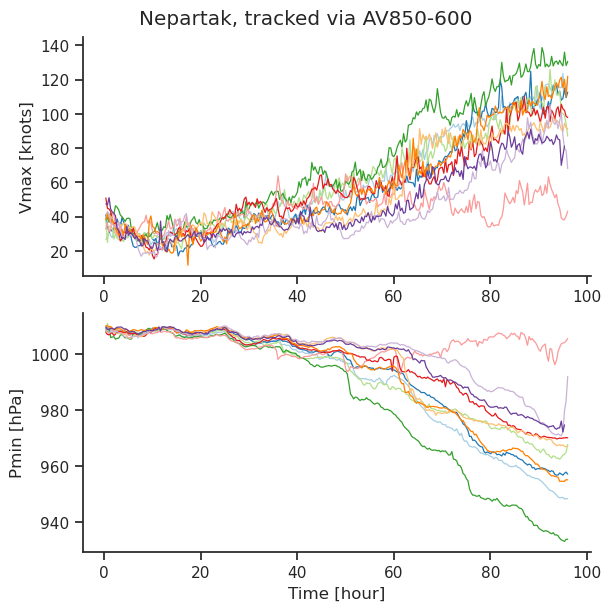

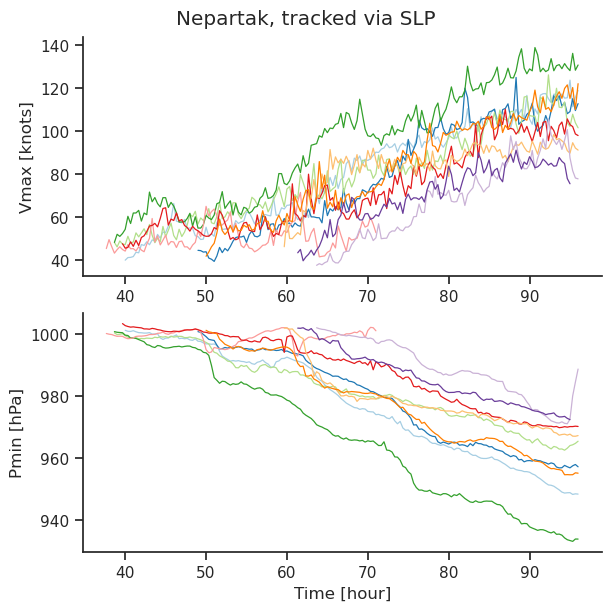

In [25]:
linestyle=['solid']*nmem # this creates an array of ['solid'] of size ntest
linecolor=['black']*nmem
# Create an array of colors for each member
linecolor = sns.color_palette("Paired", n_colors=nmem)
# linecolor = sns.color_palette("colorblind", n_colors=nmem)
linewidth=[0.9]*nmem

mstoknots = 1.9438 # conversion factor from m/s to knots

# create figure
fig_x = 6
fig_y = 6
for itrack in range(ntracks):

    title = case.capitalize()+', tracked via '+track_tags[itrack]
    fig, axx = plt.subplots(2, 1, figsize=(fig_x,fig_y), layout="constrained",) # row, column
    fig.suptitle(title)

    # Create loop and get counter
    for ivar, ax in enumerate(axx):  # Use enumerate to get the counter `i` and the axis `ax`

        iunits = units[ivar]
        if plot_vars[ivar] == 'vmax':
            iunits = 'knots'
        ax.set_ylabel(plot_vars[ivar].capitalize()+' ['+iunits+']')
        if ivar == 1:
            ax.set_xlabel('Time [hour]')

        # Time labels
        # ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        # ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

        for imemb in range(nmem):
            tser = all_vars[ivar, itrack, imemb, :]
            # Convert to knots if needed
            factor = 1
            if plot_vars[ivar] == 'vmax':
                factor = mstoknots
            # Smooth time series
            # tser = smooth_tser(tser)
            ax.plot(times, tser*factor, linestyle=linestyle[imemb], color=linecolor[imemb], linewidth=linewidth[imemb], alpha=1)
            # mean, low, high = mean_confidence_interval(tser)
            # ax[iprof].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            # if conf_shading:
            #     if (itest == 0) or (itest == 1):
            #         xdim = range(0,i_nt)
            #         ax[iprof].fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
# if do_legend:
#     ax[0].legend(loc="upper right")
plt.show()